In [ ]:
from google.colab import files
import zipfile
import os

# Upload do arquivo zip
uploaded = files.upload()

# Extração do arquivo zip
for file_name in uploaded.keys():
    with zipfile.ZipFile(file_name, 'r') as zip_ref:
        zip_ref.extractall('data')

# Verificando a estrutura das pastas
print("Diretórios extraídos:", os.listdir('data'))

Saving data.zip to data.zip
Diretórios extraídos: ['glioma', 'no_tumor']


In [ ]:
import os

# Caminho base das pastas
base_dir = 'data'

# Listar os diretórios (classes)
classes = os.listdir(base_dir)
print("Classes encontradas:", classes)

# Contar imagens em cada classe
for cls in classes:
    class_path = os.path.join(base_dir, cls)
    num_images = len(os.listdir(class_path))
    print(f"Número de imagens em {cls}: {num_images}")

Classes encontradas: ['glioma', 'no_tumor']
Número de imagens em glioma: 826
Número de imagens em no_tumor: 395


In [ ]:
import shutil
from sklearn.model_selection import train_test_split

# Criando as pastas
base_train_dir = os.path.join(base_dir, 'train')
base_val_dir = os.path.join(base_dir, 'val')
base_test_dir = os.path.join(base_dir, 'test')

for dir_path in [base_train_dir, base_val_dir, base_test_dir]:
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)

# Movendo os arquivos
def move_files(file_list, target_dir):
    for file in file_list:
        shutil.move(file, target_dir)

# Divisão dos dados para cada classe
for cls in classes:
    class_path = os.path.join(base_dir, cls)
    images = [os.path.join(class_path, img) for img in os.listdir(class_path)]

# Dividindo em treino, validação e teste
    train_files, temp_files = train_test_split(images, test_size=0.3, random_state=42)
    val_files, test_files = train_test_split(temp_files, test_size=0.5, random_state=42)

# Criando subpastas para as classes
    for dataset, dataset_files in zip([base_train_dir, base_val_dir, base_test_dir], [train_files, val_files, test_files]):
        class_dir = os.path.join(dataset, cls)
        if not os.path.exists(class_dir):
            os.makedirs(class_dir)
        move_files(dataset_files, class_dir)

print("Divisão concluída!")

Divisão concluída!


In [ ]:
# Verificar distribuição das imagens
for dataset in ['train', 'val', 'test']:
    print(f"\nConteúdo de {dataset}:")
    for cls in classes:
        cls_dir = os.path.join(base_dir, dataset, cls)
        num_images = len(os.listdir(cls_dir))
        print(f"  Classe '{cls}': {num_images} imagens")


Conteúdo de train:
  Classe 'glioma': 578 imagens
  Classe 'no_tumor': 276 imagens

Conteúdo de val:
  Classe 'glioma': 124 imagens
  Classe 'no_tumor': 59 imagens

Conteúdo de test:
  Classe 'glioma': 124 imagens
  Classe 'no_tumor': 60 imagens


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Criando geradores de dados
train_datagen = ImageDataGenerator(
    rescale=1.0/255,           # Normalizar os valores dos pixels para [0, 1]
    rotation_range=20,         # Rotação aleatória de até 20 graus
    width_shift_range=0.2,     # Deslocamento horizontal
    height_shift_range=0.2,    # Deslocamento vertical
    shear_range=0.2,           # Cisalhamento
    zoom_range=0.2,            # Zoom
    horizontal_flip=True,      # Espelhamento horizontal
    fill_mode='nearest'        # Preenchimento para regiões vazias após transformação
)
val_test_datagen = ImageDataGenerator(rescale=1.0/255)
# Configurar geradores
batch_size = 32
target_size = (150, 150)

train_generator = train_datagen.flow_from_directory(
    os.path.join(base_dir, 'train'),
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary'
)

val_generator = val_test_datagen.flow_from_directory(
    os.path.join(base_dir, 'val'),
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = val_test_datagen.flow_from_directory(
    os.path.join(base_dir, 'test'),
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False  # Não embaralhar para garantir previsibilidade
)

print("Geradores configurados com sucesso!")

Found 854 images belonging to 2 classes.
Found 183 images belonging to 2 classes.
Found 184 images belonging to 2 classes.
Geradores configurados com sucesso!


In [ ]:
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Construindo o modelo CNN com L2 regularization
model = Sequential([
    # Primeira camada convolucional com regularização L2
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3),
           kernel_regularizer=regularizers.l2(0.01)),
    MaxPooling2D(pool_size=(2, 2)),

    # Segunda camada convolucional com regularização L2
    Conv2D(64, (3, 3), activation='relu',
           kernel_regularizer=regularizers.l2(0.01)),
    MaxPooling2D(pool_size=(2, 2)),

    # Terceira camada convolucional com regularização L2
    Conv2D(128, (3, 3), activation='relu',
           kernel_regularizer=regularizers.l2(0.01)),
    MaxPooling2D(pool_size=(2, 2)),

    # Camada de flattening (achatamento)
    Flatten(),

    # Camadas totalmente conectadas com regularização L2
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.7),  # Reduzir overfitting
    Dense(1, activation='sigmoid')  # Saída binária
])

# Resumo do modelo
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       4,735,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,828,481 (18.42 MB)

 Trainable params: 4,828,481 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.optimizers import Adam

# Compilar o modelo
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [ ]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,  #Interromper se não houver melhora após 3 épocas
    restore_best_weights=True
)
# Treinar o modelo

history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stopping]
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


27/27 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.6714 - loss: 3.0599 - val_accuracy: 0.7158 - val_loss: 1.3703
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.7437 - loss: 1.2106 - val_accuracy: 0.8852 - val_loss: 0.8413
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.7841 - loss: 0.8627 - val_accuracy: 0.8361 - val_loss: 0.6710
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.7665 - loss: 0.7880 - val_accuracy: 0.8251 - val_loss: 0.5925
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.7856 - loss: 0.7361 - val_accuracy: 0.8798 - val_loss: 0.5567
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.8522 - loss: 0.5998 - val_accuracy: 0.9508 - val_loss: 0.4729
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.8752 - loss: 0.5854 - val_accuracy: 0.9344 - val_loss: 0.4245
Epoch 8/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.8765 - loss: 0.5074 - val_accuracy: 0.9672 - val_loss: 0.3813
Epo

In [ ]:
# Avaliando o conjunto de teste
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Loss: {test_loss}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 425ms/step - accuracy: 0.9831 - loss: 0.2989
Test Accuracy: 0.95652174949646
Test Loss: 0.3549581468105316


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Obter previsões
test_generator.reset()
y_pred = model.predict(test_generator)
y_pred = np.where(y_pred > 0.5, 1, 0)  # Converter para 0/1

# Verdadeiros rótulos
y_true = test_generator.classes

# Matriz de confusão
cm = confusion_matrix(y_true, y_pred)
print("Matriz de Confusão:\n", cm)

6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 555ms/step
Matriz de Confusão:
 [[124   0]
 [  8  52]]


In [ ]:
# Relatório de classificação
report = classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys())
print("Relatório de Classificação:\n", report)

Relatório de Classificação:
               precision    recall  f1-score   support

      glioma       0.94      1.00      0.97       124
    no_tumor       1.00      0.87      0.93        60

    accuracy                           0.96       184
   macro avg       0.97      0.93      0.95       184
weighted avg       0.96      0.96      0.96       184



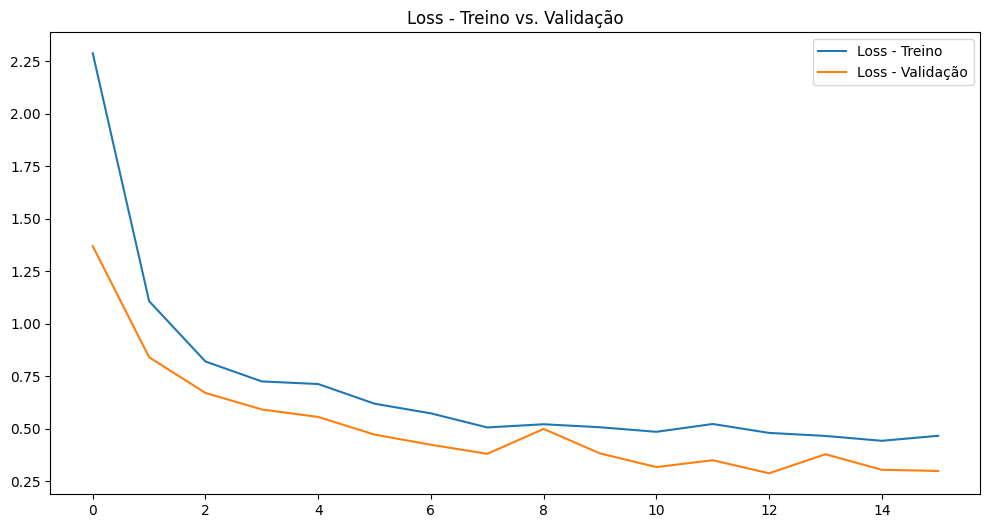

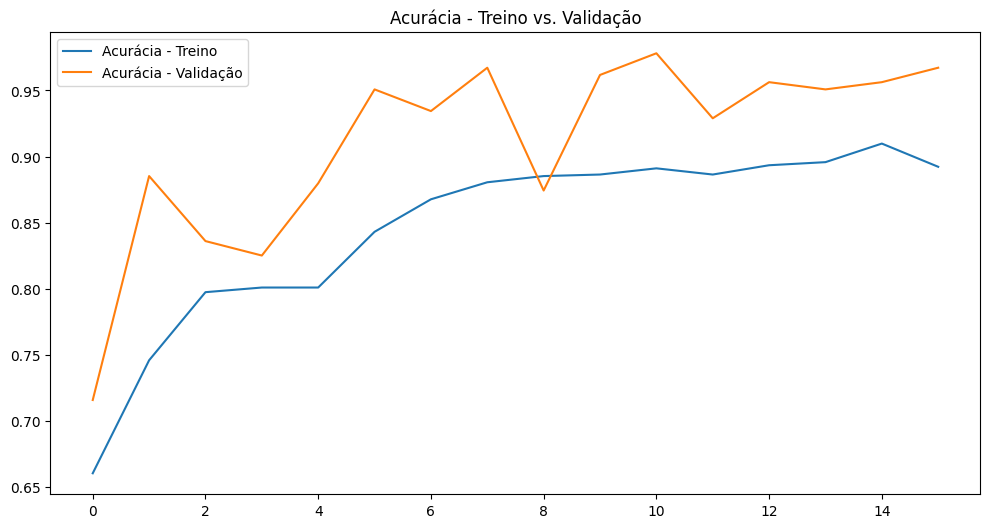

In [ ]:
import matplotlib.pyplot as plt

# Gráfico de Loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Loss - Treino')
plt.plot(history.history['val_loss'], label='Loss - Validação')
plt.legend()
plt.title('Loss - Treino vs. Validação')
plt.show()

# Gráfico de Acurácia
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Acurácia - Treino')
plt.plot(history.history['val_accuracy'], label='Acurácia - Validação')
plt.legend()
plt.title('Acurácia - Treino vs. Validação')
plt.show()

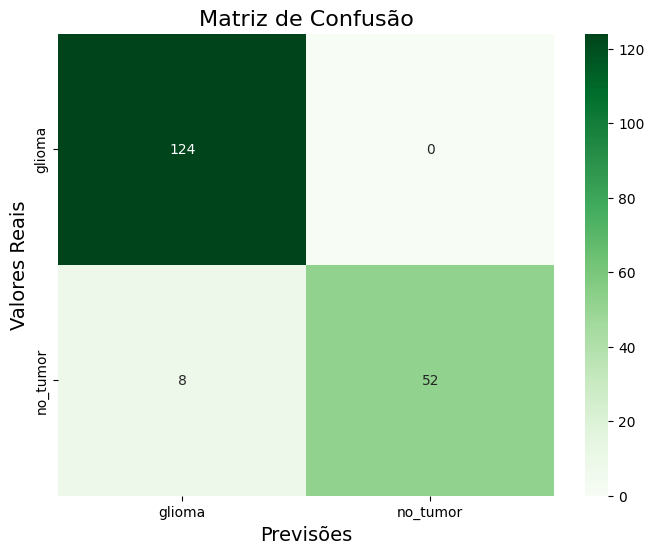

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Valores da matriz de confusão (substitua pelos seus)
y_true = [0] * 124 + [1] * 60  # Labels reais
y_pred = [0] * 124 + [1] * 52 + [0] * 8  # Previsões do modelo

# Calcula a matriz de confusão
cm = confusion_matrix(y_true, y_pred)

# Define os rótulos
labels = ["glioma", "no_tumor"]

# Cria o heatmap com colormap em tons de verde
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Greens", xticklabels=labels, yticklabels=labels)

# Configurações da matriz
plt.title("Matriz de Confusão", fontsize=16)
plt.xlabel("Previsões", fontsize=14)
plt.ylabel("Valores Reais", fontsize=14)
plt.show()
